Populating the interactive namespace from numpy and matplotlib
HLA-B
HLA-B


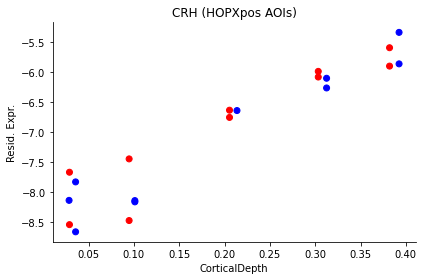

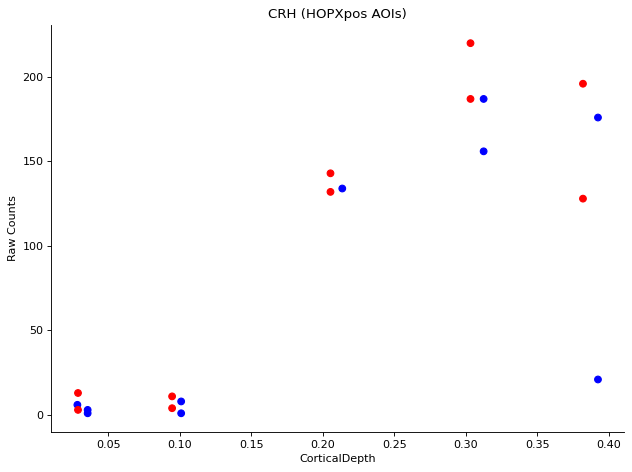

In [5]:
## Get the number of genes above LOD as a function of nuclei number:
%pylab inline
import pandas as pd
import sys, ast, os
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
import pickle as pickle
import numpy as np
import time
import itertools
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'floatX=' + data_type #+ ',force_device=True'
%matplotlib inline
import anndata
import scanpy as sc
import theano.tensor as tt
import pymc3 as pm
#gfd
import theano
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import os
import NaiveDE
import SpatialDE
import statsmodels.stats.multitest as multi
import scipy.stats as ss

os.chdir('/nfs/team283/aa16/KR_NAS/')
rSlides = ('00MU', '00MV', '00MV-2')
AOI_type = 'Geometric'
Radial_position = 2

# Let's load the data and metadata from our Nanostring experiment:
counts = pd.read_table('Sanger_288ROIs_TargetCountMatrix.txt')
genes = counts['TargetName']
counts = counts.drop('TargetName',1)
counts = counts.rename(index=genes)
counts = counts.astype('int')
counts = counts[np.array([sum(counts.iloc[i,:]) for i in range(len(counts.iloc[:,0]))]) > 3 * 288]
metadata = pd.read_csv('NanoString sequencing all annotations 2020.02.10.csv')
metadata = metadata.iloc[0:286,]
metadata = metadata.rename(index=metadata['Sanger_sampleID'])
metadata = metadata.reindex(np.array(counts.columns))
properties = pd.read_table('Sanger_288ROIs_SegmentProperties.txt')
properties = properties.rename(index=properties['DSP_Sample_ID'])
properties = properties.reindex(np.array(metadata['Sample_ID']))
columnNames = ('x', 'y', 'total_counts', 'Q3_counts')
sample_info = pd.DataFrame(index=metadata['Sample_ID'], columns=columnNames)
sample_info['x'] = np.array(metadata['VCDepth'])
sample_info['y'] = np.array(metadata['Radial_position'])
sample_info['total_counts'] = [sum(counts.iloc[:,i]) for i in range(len(counts.iloc[1,:]))] 
sample_info['Q3_counts'] = [sum(np.sort(counts.iloc[:,i])[int(np.round(0.5*len(counts.iloc[:,i]))):int(np.round(0.75*len(counts.iloc[:,i])))]) for i in range(len(counts.iloc[1,:]))] 

# Let's load the Polioudakis 2019 data as a reference, as well as the cell type specific marker genes:

polioudakis = pd.read_csv('/nfs/team283/aa16/data/fetalBrain/Polioudakis/cellStateMatrix.csv')
genes = polioudakis.iloc[:,0]
polioudakis = polioudakis.drop('Unnamed: 0',1)
polioudakis = polioudakis.rename(index=genes)

subset_rois = [metadata['age'][i] == '19pcw' and metadata['slide'][i] in rSlides and metadata['Radial_position'][i] == Radial_position and metadata['AOI_type'][i] == AOI_type for i in range(len(metadata['slide']))]
relevantIDs = metadata['Sample_ID'][subset_rois]
relevantSangerIDs = metadata['Sanger_sampleID'][subset_rois]
counts_subset = counts.loc[:,relevantSangerIDs]
properties_subset = properties.loc[np.array(relevantIDs),:]
newLOD_2_subset = properties_subset['NegGeoMean_01']*(properties_subset['NegGeoSD_01']**2) 

# Load all the receptor-ligand pairs from CellPhoneDB:

cellPhoneDB_geneInput = pd.read_csv('/nfs/team283/aa16/data/CellPhoneDB/gene_input.csv')
cellPhoneDB_geneInput = cellPhoneDB_geneInput.drop_duplicates(subset = 'uniprot')
cellPhoneDB_geneInput.index = cellPhoneDB_geneInput['uniprot']
cellPhoneDB_proteinInput = pd.read_csv('/nfs/team283/aa16/data/CellPhoneDB/protein_input.csv')
cellPhoneDB_proteinInput = cellPhoneDB_proteinInput.drop_duplicates(subset = 'uniprot')
cellPhoneDB_geneInput = cellPhoneDB_geneInput.reindex(np.array(cellPhoneDB_proteinInput['uniprot']))

cellPhoneDB_genes_ligand = cellPhoneDB_geneInput['gene_name'].iloc[np.array(~cellPhoneDB_proteinInput['receptor'])]
cellPhoneDB_genes_receptor = cellPhoneDB_geneInput['gene_name'].iloc[np.array(cellPhoneDB_proteinInput['receptor'])]
receptors = cellPhoneDB_genes_receptor[[cellPhoneDB_genes_receptor[i] in np.array(counts.index) for i in range(len(cellPhoneDB_genes_receptor))]]

# Find all receptors expressed in EOMESplus population and check if their ligands' expression varies with cortical depth:

subset_eomes = [metadata['age'][i] == '19pcw' and metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3) and metadata['AOI_type'][i] == 'EOMESpos' for i in range(len(metadata['slide']))]
relevantSangerIDs = metadata['Sanger_sampleID'][subset_eomes]
relevantIDs = metadata['Sample_ID'][subset_eomes]
counts_subset = counts.loc[np.array(receptors),relevantSangerIDs]
properties_subset = properties.loc[np.array(relevantIDs),:]
newLOD_2_subset = properties_subset['NegGeoMean_01']*(properties_subset['NegGeoSD_01']**2) 

binary = [sum([counts_subset.loc[receptors[i]].iloc[j] > newLOD_2_subset.iloc[j] for j in range(len(newLOD_2_subset))]) > 10 for i in range(len(receptors))]
receptors = receptors[binary]

# receptors_proteins[0] in np.array(cellPhoneDB_interactions['partner_a'])

# Find ligands for these receptors:

cellPhoneDB_interactions = pd.read_csv('/nfs/team283/aa16/data/CellPhoneDB/interaction_input.csv')
receptors_proteins = [cellPhoneDB_geneInput.index[np.where(cellPhoneDB_geneInput['gene_name'] == receptors[i])][0] for i in range(len(receptors))]

ligand_proteins = np.repeat('EmptyEmptyEmpty', len(receptors_proteins))
for i in range(len(ligand_proteins)):
    if sum(cellPhoneDB_interactions['partner_a'] == receptors_proteins[i]) > 0:
        ligand_proteins[i] = cellPhoneDB_interactions['partner_b'].loc[cellPhoneDB_interactions['partner_a'] == receptors_proteins[i]].iloc[0]
    if sum(cellPhoneDB_interactions['partner_b'] == receptors_proteins[i]) > 0:
        ligand_proteins[i] = cellPhoneDB_interactions['partner_a'].loc[cellPhoneDB_interactions['partner_b'] == receptors_proteins[i]].iloc[0]

receptors_proteins = np.array(receptors_proteins)    
sub = [ligand_proteins[i] != 'EmptyEmptyEmpty' and ligand_proteins[i] != 'BMPR1B_BMPR2' for i in range(len(ligand_proteins))]
receptors_proteins = receptors_proteins[sub]
ligand_proteins = ligand_proteins[sub]

eomes_ligand_genes = [np.array(cellPhoneDB_geneInput['gene_name'])[np.array(cellPhoneDB_geneInput['uniprot'] == ligand_proteins[i])][0] for i in range(len(ligand_proteins))]

eomes_receptor_genes = [np.array(cellPhoneDB_geneInput['gene_name'])[np.array(cellPhoneDB_geneInput['uniprot'] == receptors_proteins[i])][0] for i in range(len(ligand_proteins))]

print(eomes_receptor_genes[eomes_ligand_genes == 'CRH'])
print(eomes_receptor_genes[eomes_ligand_genes == 'ERBB4'])


eomes_ligand_genes = np.unique(eomes_ligand_genes)

# 1.) Check expression patterns of CRH in HOPX+ AOIs:

subset_hopX = [metadata['age'][i] == '19pcw' and metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3) and metadata['AOI_type'][i] == 'HOPXpos' for i in range(len(metadata['slide']))]
relevantSangerIDs = metadata['Sanger_sampleID'][subset_hopX]
relevantIDs = metadata['Sample_ID'][subset_hopX]
counts_subset = counts.loc[:,relevantSangerIDs]
properties_subset = properties.loc[np.array(relevantIDs),:]
newLOD_2_subset = properties_subset['NegGeoMean_01']*(properties_subset['NegGeoSD_01']**2) 

binary = [sum([counts_subset.loc[receptors[i]].iloc[j] > newLOD_2_subset.iloc[j] for j in range(len(newLOD_2_subset))]) > 10 for i in range(len(receptors))]
receptors = receptors[binary]

norm_expr = NaiveDE.stabilize(counts.T).T

resid_expr = NaiveDE.regress_out(sample_info, norm_expr, 'np.log(Q3_counts)').T
resid_expr_subset = resid_expr.loc[subset_hopX, ]

# Save results:

colours = np.repeat('blue', sum(subset_hopX))
colours[metadata['slide'][subset_hopX] == '00MU'] = 'red'
plt.scatter(sample_info['x'][subset_hopX], np.array(resid_expr_subset['CRH']), c=colours);
plt.title('CRH (HOPXpos AOIs)')
plt.xlabel('CorticalDepth')
plt.ylabel('Resid. Expr.')
plt.tight_layout()
#    plt.savefig('CellPhoneDB_SpatialDE_genes.png') 
plt.show()

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
colours = np.repeat('blue', sum(subset_hopX))
colours[metadata['slide'][subset_hopX] == '00MU'] = 'red'
plt.scatter(sample_info['x'][subset_hopX], np.array(counts_subset.loc['CRH',:]), c=colours);
#plt.matplotlib.pyplot.hlines(np.mean(newLOD_2_subset),0,0.5)
plt.title('CRH (HOPXpos AOIs)')
plt.xlabel('CorticalDepth')
plt.ylabel('Raw Counts')
plt.tight_layout()
#    plt.savefig('CellPhoneDB_SpatialDE_genes.png') 
plt.show()


In [18]:
# 3b.) Check expression patterns of CRHR2 in EOMES+ AOIs:

print('start')

subset_eomes = [metadata['age'][i] == '19pcw' and metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3) and metadata['AOI_type'][i] == 'EOMESpos' for i in range(len(metadata['slide']))]
relevantSangerIDs = metadata['Sanger_sampleID'][subset_eomes]
relevantIDs = metadata['Sample_ID'][subset_eomes]
counts_subset = counts.loc[np.array(receptors),relevantSangerIDs]
properties_subset = properties.loc[np.array(relevantIDs),:]
newLOD_2_subset = properties_subset['NegGeoMean_01']*(properties_subset['NegGeoSD_01']**2) 

binary = [sum([counts_subset.loc[receptors[i]].iloc[j] > newLOD_2_subset.iloc[j] for j in range(len(newLOD_2_subset))]) > 10 for i in range(len(receptors))]
receptors = receptors[binary]

norm_expr = NaiveDE.stabilize(counts.T).T

resid_expr = NaiveDE.regress_out(sample_info, norm_expr, 'np.log(Q3_counts)').T
resid_expr_subset = resid_expr.loc[subset_Eomes, ]

X = sample_info[['x', 'y']][subset_Eomes]

# Save results:

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

colours = np.repeat('blue', sum(subset_Eomes))
colours[metadata['slide'][subset_Eomes] == '00MU'] = 'red'
plt.scatter(sample_info['x'][subset_Eomes], np.array(resid_expr_subset['CRHR2']), c=colours);
plt.title('CRHR2 (EOMESpos AOIs)')
plt.xlabel('CorticalDepth')
plt.ylabel('Resid. Expr.')
plt.tight_layout()
#    plt.savefig('CellPhoneDB_SpatialDE_genes.png') 
plt.show()

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
colours = np.repeat('blue', sum(subset_Eomes))
colours[metadata['slide'][subset_Eomes] == '00MU'] = 'red'
plt.scatter(sample_info['x'][subset_Eomes], np.array(counts_subset.loc['CRHR2',:]), c=colours);
#plt.matplotlib.pyplot.hlines(np.mean(newLOD_2_subset),0,0.5)
plt.title('CRHR2 (EOMESpos AOIs)')
plt.xlabel('CorticalDepth')
plt.ylabel('Raw Counts')
plt.tight_layout()
#    plt.savefig('CellPhoneDB_SpatialDE_genes.png') 
plt.show()



start


NameError: name 'subset_Eomes' is not defined

start
32


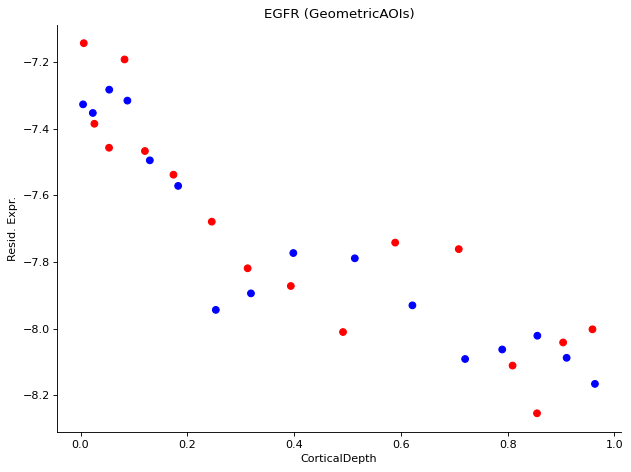

20


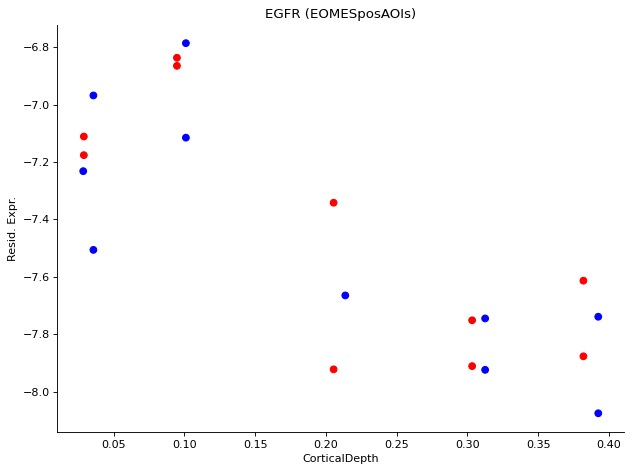

20


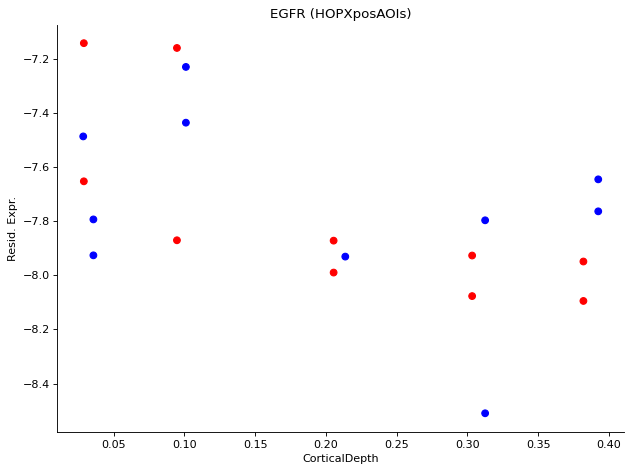

In [20]:
# 3b.) Check EGFR expression pattern in all ROIs/AOIs:

print('start')

relevantROIs = np.array(('Geometric', 'EOMESpos', 'HOPXpos'))

for x in range(len(relevantROIs)):

    subset_ROI = [metadata['age'][i] == '19pcw' and metadata['slide'][i] in rSlides and metadata['Radial_position'][i] in (1,3,2) and metadata['AOI_type'][i] == relevantROIs[x] for i in range(len(metadata['slide']))]
    print(sum(subset_ROI))
    relevantSangerIDs = metadata['Sanger_sampleID'][subset_ROI]
    relevantIDs = metadata['Sample_ID'][subset_ROI]
    counts_subset = counts.loc[:,relevantSangerIDs]
    properties_subset = properties.loc[np.array(relevantIDs),:]
    newLOD_2_subset = properties_subset['NegGeoMean_01']*(properties_subset['NegGeoSD_01']**2) 

    binary = [sum([counts_subset.loc[receptors[i]].iloc[j] > newLOD_2_subset.iloc[j] for j in range(len(newLOD_2_subset))]) > 10 for i in range(len(receptors))]
    receptors = receptors[binary]

    norm_expr = NaiveDE.stabilize(counts.T).T

    resid_expr = NaiveDE.regress_out(sample_info, norm_expr, 'np.log(Q3_counts)').T
    resid_expr_subset = resid_expr.loc[subset_ROI, ]
    
    # Save results:

    from matplotlib.pyplot import figure
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    colours = np.repeat('blue', sum(subset_ROI))
    colours[metadata['slide'][subset_ROI] == '00MU'] = 'red'
    plt.scatter(sample_info['x'][subset_ROI], np.array(resid_expr_subset['EGFR']), c=colours);
    plt.title('EGFR (' + relevantROIs[x] +'AOIs)')
    plt.xlabel('CorticalDepth')
    plt.ylabel('Resid. Expr.')
    plt.tight_layout()
    #    plt.savefig('CellPhoneDB_SpatialDE_genes.png') 
    plt.show()
    

In [16]:
metadata['AOI_type'] == 'Geometric'

HCA_F_BRA8739081    False
HCA_F_BRA8739082     True
HCA_F_BRA8739083     True
HCA_F_BRA8739084     True
HCA_F_BRA8739085     True
                    ...  
HCA_F_BRA8739364    False
HCA_F_BRA8739365     True
HCA_F_BRA8739366    False
HCA_F_BRA8739367     True
HCA_F_BRA8739368    False
Name: AOI_type, Length: 288, dtype: bool